In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from src.attribution.flextime.filterbank import Filterbank

/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


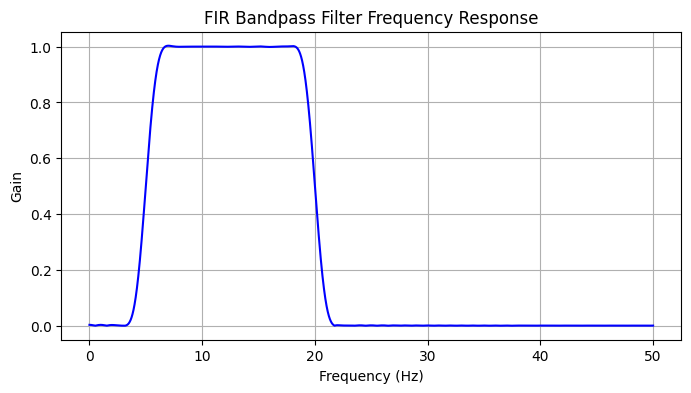

In [2]:
def fir_bandpass_filter(num_taps, lowcut, highcut, fs):
    """
    Generates a FIR bandpass filter using the windowed sinc method.
    
    Parameters:
    - num_taps (int): Length of the filter (should be odd for best symmetry).
    - lowcut (float): Lower cutoff frequency (Hz).
    - highcut (float): Upper cutoff frequency (Hz).
    - fs (float): Sampling frequency (Hz).
    - window (str): Window function (default is 'hamming').

    Returns:
    - h (numpy array): Filter coefficients.
    """

    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design FIR bandpass filter
    h = signal.firwin(num_taps, [low, high], pass_zero=False)

    return h

# Example usage
fs = 100        # Sampling frequency in Hz
num_taps = 101  # Filter length (must be odd for symmetry)
lowcut = 5      # Lower cutoff frequency in Hz
highcut = 20    # Upper cutoff frequency in Hz

h = fir_bandpass_filter(num_taps, lowcut, highcut, fs)

# Plot frequency response
w, h_response = signal.freqz(h, worN=8000)
plt.figure(figsize=(8, 4))
plt.plot((fs * 0.5 / np.pi) * w, np.abs(h_response), 'b')
plt.title("FIR Bandpass Filter Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.grid()
plt.show()

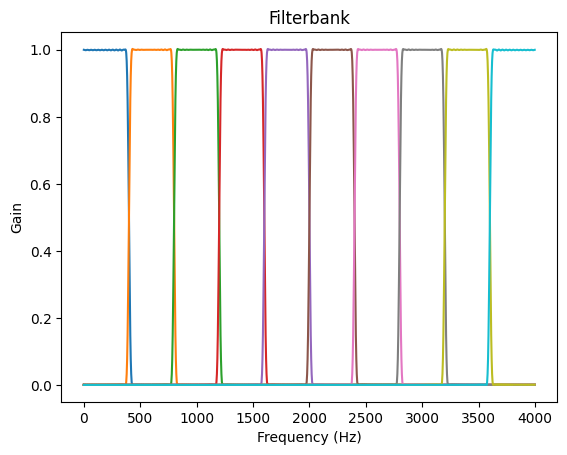

In [3]:
num_taps = 501      # how sharp the filter is (squaredness)
n_filters = 10      # number of filters
sample_freq = 8000  # changes x axis
bandwidth = 400     # changes bandwidth of each filter

filterbank = Filterbank(num_taps, n_filters, sample_freq, bandwidth)

# Plot frequency responses
filterbank.plot_filterbank()

In [4]:
# load sleepedf data for testing
from physioex.physioex.data import PhysioExDataModule

datamodule = PhysioExDataModule(
    datasets=["sleepedf"],
    batch_size=960,
    preprocessing="raw",
    selected_channels=["EEG", "EOG", "EMG"],
    sequence_length=1,
    data_folder="./data"
)

print(datamodule)

test_loader = datamodule.test_dataloader()
print(len(test_loader))

{Train dataloader: size=131366}
{Validation dataloader: size=36690}
{Test dataloader: size=26388}
{Predict dataloader: None}
28


In [15]:
# apply the filterbank to the first batch
for batch in test_loader:

    x, y = batch
    x = x.numpy() # shape (N, C, T) - num sequences, num channels, samples per sequence (30s * 100Hz)
    y = y.numpy()

    print(x.shape)
    print(y.shape)

    # Apply the filterbank to the data
    # filtered_data = filterbank.apply_filterbank(x)

    break

(960, 1, 3, 3000)
(960, 1)


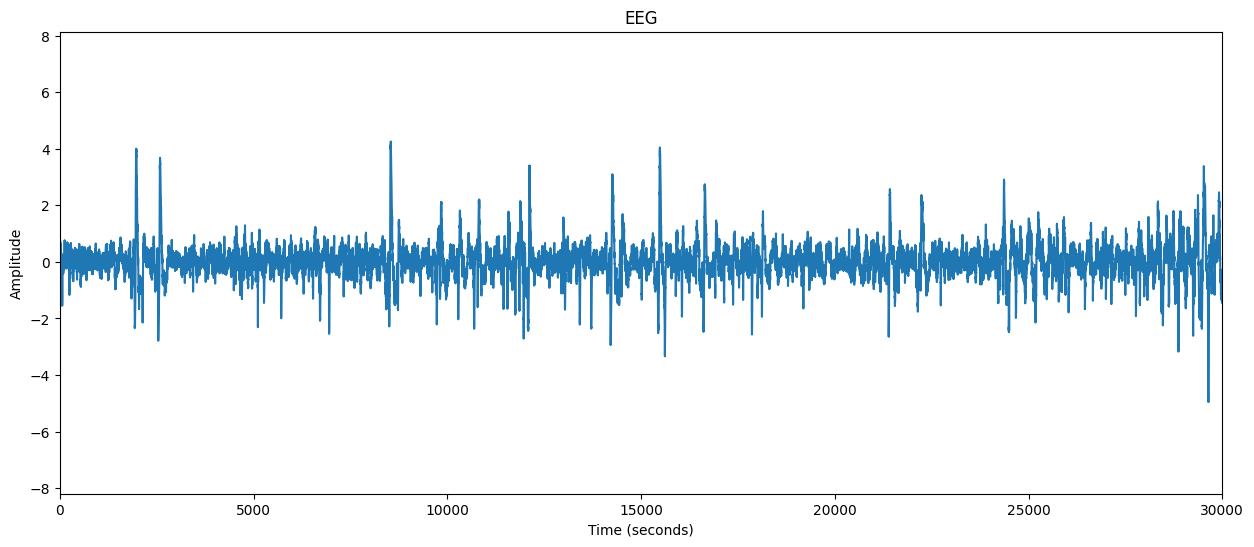

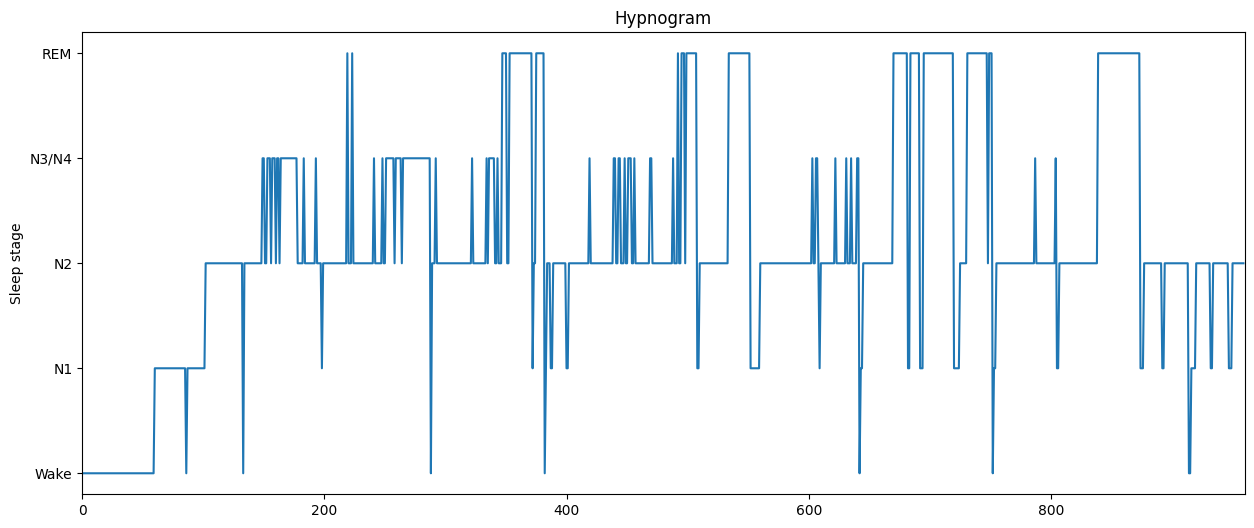

In [24]:
# plot different sequences of the data, showing the different channels
eeg = []
eog = []
emg = []

for i in range(len(x)):
    eeg.append(x[i][0][0])
    # eog.append(x[i][3][1])
    # emg.append(x[i][3][2])

eeg = np.array(eeg).flatten()
# eog = np.array(eog)
# emg = np.array(emg)

eeg = eeg.squeeze()
# eog = eog.squeeze()
# emg = emg.squeeze()

plt.figure(figsize=(15, 6))
plt.plot(eeg, label='EEG')
plt.title('EEG')
plt.xlim(0, 30000)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y)
plt.title('Hypnogram')
plt.xlim(0, 960)
plt.ylabel('Sleep stage')
# set the labels
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3/N4', 'REM'])
plt.show()



# plt.figure(figsize=(12, 6))
# plt.plot(eog, label='EOG', color='green')
# plt.title('EOG')
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(emg, label='EMG', color='blue')
# plt.title('EMG')
# plt.show()



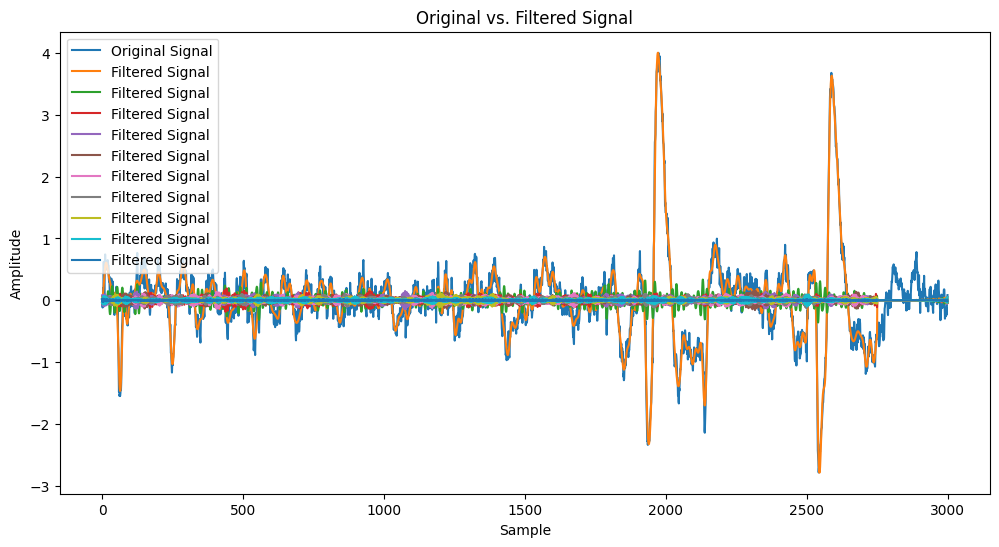

In [ ]:
# Plot the original and filtered signals first 30s window of the first sequence
plt.figure(figsize=(12, 6))
plt.plot(x[0][0], label="Original Signal")
# plt.plot(filtered_data[0][0], label="Filtered Signal")
plt.title("Original vs. Filtered Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend(loc="upper left")
plt.show()

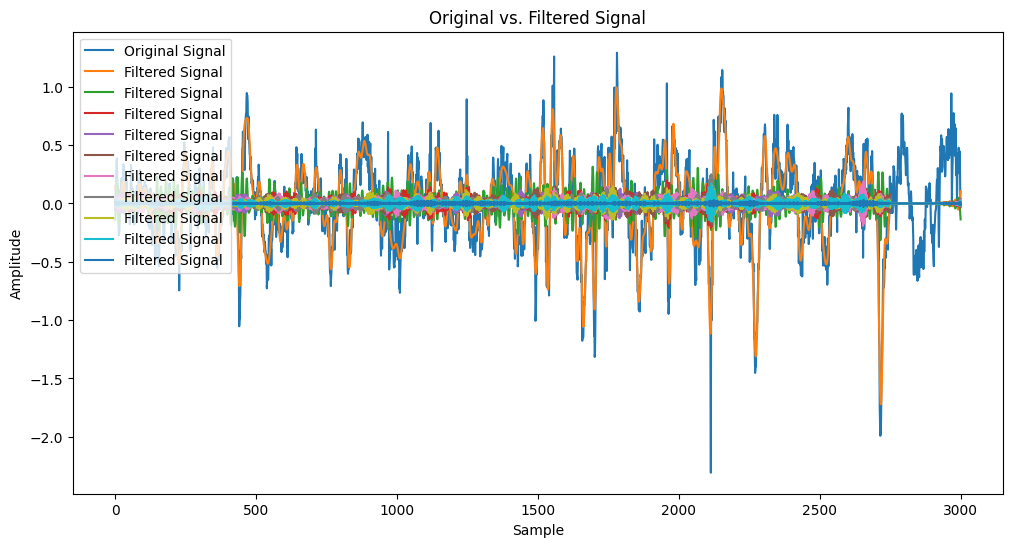

In [8]:
# Plot the original and filtered signals first 30s window of the second sequence
plt.figure(figsize=(12, 6))
plt.plot(x[1][0], label="Original Signal")
plt.plot(filtered_data[1][0], label="Filtered Signal")
plt.title("Original vs. Filtered Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend(loc="upper left")
plt.show()

In [22]:
# simulate data
import numpy as np
import matplotlib.pyplot as plt
from src.data_gen import generate_signal

num_samples = 10  # Number of samples per class
# Parameters
fs = 100  # Sampling rate
T = 30      # Duration in seconds
N = fs * T # Number of samples
t = np.linspace(0, T, N)

samples_0 = [generate_signal([5, 20], [7, 21], [1, 0.7], fs=fs, T=T) for _ in range(num_samples)]
samples_1 = [generate_signal([20, 5], [7, 21], [1, 0.7], fs=fs, T=T) for _ in range(num_samples)]


In [7]:
# Load and shape synthetic test data
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/train_1"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# create the dataset
dataset = TensorDataset(x, y)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128, shuffle=True)


(50000, 1, 1000)
(50000,)


(128, 1, 1000)
(128,)


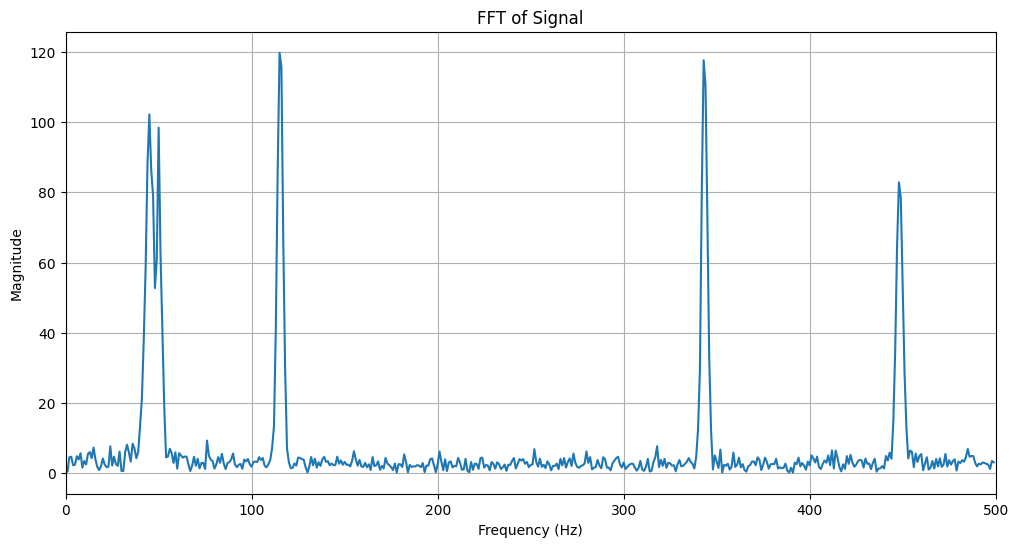

In [8]:
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt

# print fft of the first batch
for batch in test_loader:
    x, y = batch
    x = x.squeeze(0).numpy() # shape (N, C, T) - num sequences, num channels, samples per sequence (1s * 1000Hz)
    y = y.squeeze(0).numpy()

    print(x.shape)
    print(y.shape)

    # compute fft
    # Compute FFT
    N = len(x[0][0])
    freq = fftfreq(N, d=1/1000)  # Frequency bins
    magnitude = np.abs(fft(x[0][0]))  # Magnitude of FFT

    # Keep only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    magnitude = magnitude[pos_mask]

    # plot the fft of the first sequence
    plt.figure(figsize=(12, 6))
    plt.plot(freq, magnitude)
    plt.title("FFT of Signal")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xlim(0, 1000/2)  # Limit x-axis to Nyquist frequency
    plt.grid()
    plt.show()

    break

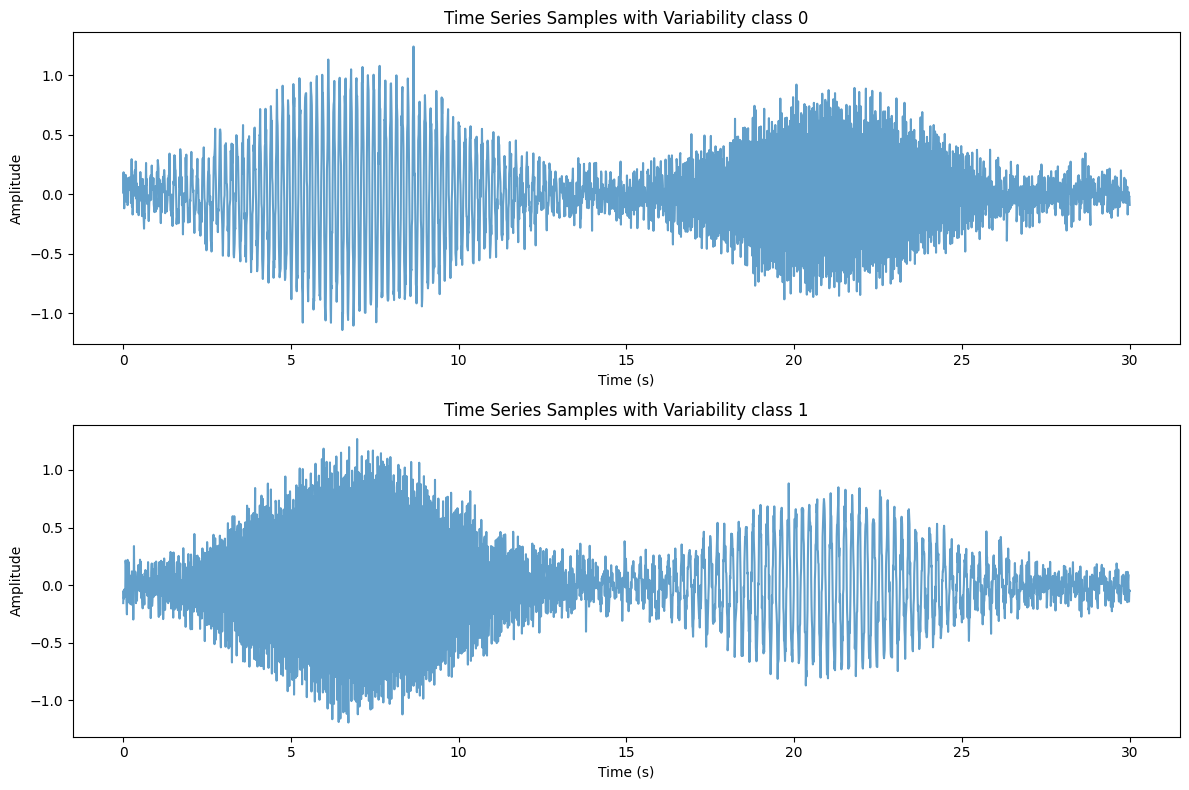

In [26]:
# Plot some samples
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
for i in range(1):  # Show three samples per class
    axs[0].plot(t, samples_0[i], alpha=0.7)
    axs[1].plot(t, samples_1[i], alpha=0.7)

axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Time Series Samples with Variability class 0")

axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")
axs[1].set_title("Time Series Samples with Variability class 1")

fig.tight_layout()
plt.show()

In [36]:
def plot_wavelet_filters(family, vanishing_moments):
    """
    Plots the four filters associated with a given wavelet family and order.

    Args:
        family (str): The wavelet family name (e.g., 'db', 'sym', 'coif').
        vanishing_moments (int): The number of vanishing moments (the 'N' in dbN).
    """
    # Construct the full wavelet name (e.g., 'db4')
    wavelet_name = f"{family}{vanishing_moments}"

    # --- 1. Get the Wavelet Object and Filters ---
    try:
        wavelet = pywt.Wavelet(wavelet_name)
    except ValueError:
        print(f"Error: The wavelet '{wavelet_name}' does not exist in PyWavelets.")
        print("Please check the family name and number of vanishing moments.")
        # For example, 'sym1' does not exist, starts at 'sym2'.
        # 'coif' N must be between 1 and 5.
        return

    # Extract the four filters
    # These are the raw filter coefficients (impulse response)
    dec_lo = wavelet.dec_lo  # Decomposition Low-pass
    dec_hi = wavelet.dec_hi  # Decomposition High-pass

    filters = {
        'Decomposition Low-pass': dec_lo,
        'Decomposition High-pass': dec_hi,
    }
    
    # --- 2. Create the Plot ---
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
    # fig.suptitle(f"Filters for {wavelet.name.capitalize()} Wavelet (N={vanishing_moments})", fontsize=18)
    
    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    for i, (title, coeffs) in enumerate(filters.items()):
        ax = axs[i]
        
        # Create an x-axis for the coefficients
        x_axis = np.arange(len(coeffs))
        
        # Plot using a stem plot for discrete coefficients
        markerline, stemlines, baseline = ax.stem(
            x_axis, coeffs, basefmt='gray'
        )
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'markersize', 6)
        
        # Add a connecting line to guide the eye
        ax.plot(x_axis, coeffs, 'c--', alpha=0.5)

        # Formatting
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Coefficient Index")
        if i == 0:
            ax.set_ylabel("Value")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.axhline(0, color='black', linewidth=0.7)
        ax.set_xticks(x_axis) # Ensure all integer indices are shown

    plt.show()

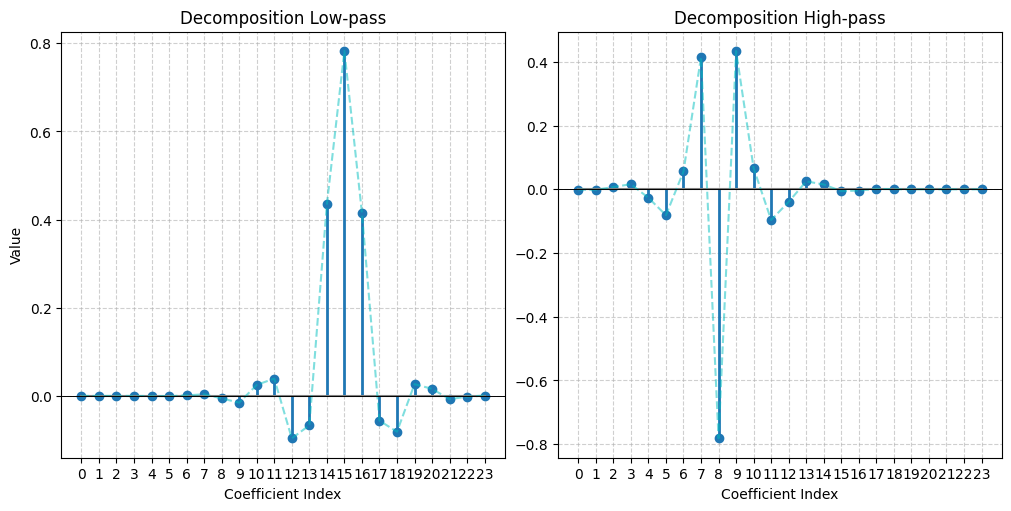

In [42]:
import pywt 

# define the db1 wavelet
plot_wavelet_filters('coif', 4)

